In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from tabulate import tabulate


from src.train import train, test
from src.models import Simple3BlockCNN, BNDropout3BlockCNN, AIDetectorResNet, SimpleResNetCNN
from src.utils import split_data, print_history

Using device: mps


# AI Detection

In [2]:
FREEZE_BACKBONE = True
DROPOUT_RATE = 0.7

BATCH_SIZE = 32
TRAIN_SIZE = 0.8
EPOCHS = 30
LEARNING_RATE = 1e-4
PATIENCE = 5

train_loader, val_loader, test_loader = split_data(root_dir="data/ai-images", batch_size=BATCH_SIZE)

           Train    Val    Test    Total
-------  -------  -----  ------  -------
Samples      754     94      96      944
Batches       24      3       3       30


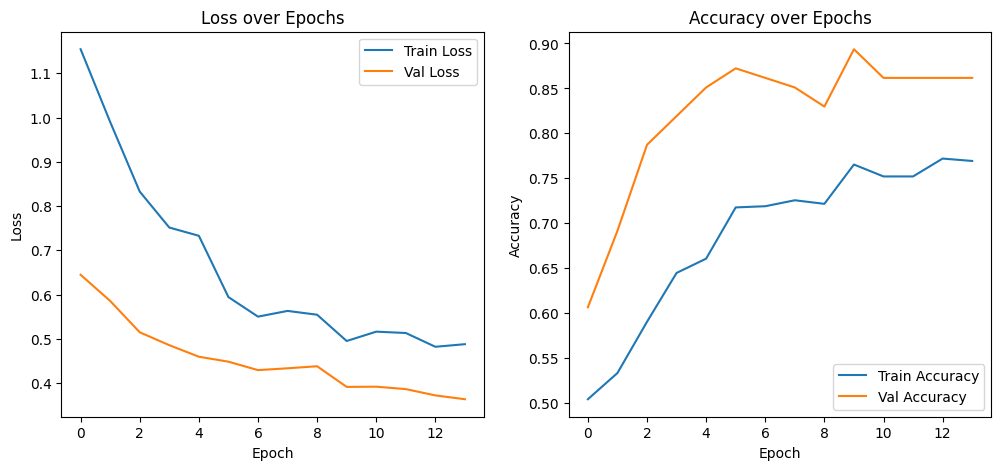

Epoch 14/30
  Train Loss: 0.4880, Train Acc: 0.7692
  Val   Loss: 0.3636, Val   Acc: 0.8617
  Best Val Acc: 0.8936 at Epoch 10
  Learning Rate: 0.000100


Early stopping at epoch 15
History saved to models/AIDetectorResNet/run_3/history.json


In [3]:
model = AIDetectorResNet(
    freeze_backbone=FREEZE_BACKBONE,
    dropout_rate=DROPOUT_RATE
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.backbone.fc.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    patience=PATIENCE
)

In [2]:
history_path = "models/AIDetectorResNet/run_3/history.json"
print_history(history_path)

Epoch      Train Loss    Val Loss    Train Acc    Val Acc
-------  ------------  ----------  -----------  ---------
1              1.1546      0.6448       0.504      0.6064
2              0.9901      0.5857       0.5332     0.6915
3              0.8328      0.5149       0.5902     0.7872
4              0.7516      0.4858       0.6446     0.8191
5              0.733       0.4597       0.6605     0.8511
6              0.5944      0.4485       0.7175     0.8723
7              0.5503      0.4294       0.7188     0.8617
8              0.5632      0.4335       0.7255     0.8511
9              0.5546      0.4382       0.7215     0.8298
10*            0.4952      0.3915       0.7653     0.8936
11             0.5163      0.3919       0.752      0.8617
12             0.5133      0.3865       0.752      0.8617
13             0.4821      0.3723       0.7719     0.8617
14             0.488       0.3636       0.7692     0.8617
15             0.4572      0.3544       0.7891     0.8617

Best val acc:

# Testing

In [4]:
model = AIDetectorResNet()
model_path = "models/AIDetectorResNet/run_3/best_model.pth"
model.load_state_dict(torch.load(model_path))

criterion = nn.BCEWithLogitsLoss()

test_result = test(model=model,
                   test_loader=test_loader,
                   criterion=criterion)

In [5]:
table_data = [
    ["AIDetectorResNet", round(test_result[0], 3), test_result[1]]
]

headers = ["Model", "Loss", "Accuracy"]

print(tabulate(table_data, headers=headers))

Model               Loss    Accuracy
----------------  ------  ----------
AIDetectorResNet   0.368     0.90625


In [4]:
from torchsummary import summary

model = AIDetectorResNet()

# Get input size from the first batch
sample_input, _ = next(iter(test_loader))
input_size = sample_input[0].shape

# Print model summary
summary(model, input_size=input_size)


/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tsigall/repositories/WatchdogAI/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [4]:
# move images
import os
import shutil
import random

# Set up paths
raw_data_dir = "data/raw-data"
output_base = "data/ai-images"
train_dir = os.path.join(output_base, "train", "true")
val_dir = os.path.join(output_base, "val", "true")
test_dir = os.path.join(output_base, "test", "true")

# Get all image files
image_files = [f for f in os.listdir(raw_data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
random.shuffle(image_files)

# Calculate split indices
total = len(image_files)
train_end = int(total * 0.8)
val_end = train_end + int(total * 0.1)

# Split files
train_files = image_files[:train_end]
val_files = image_files[train_end:val_end]
test_files = image_files[val_end:]

# Move files to respective directories
for file in train_files:
    shutil.copy2(os.path.join(raw_data_dir, file), os.path.join(train_dir, file))
for file in val_files:
    shutil.copy2(os.path.join(raw_data_dir, file), os.path.join(val_dir, file))
for file in test_files:
    shutil.copy2(os.path.join(raw_data_dir, file), os.path.join(test_dir, file))

print(f"Moved {len(train_files)} files to train, {len(val_files)} to val, and {len(test_files)} to test")

Moved 377 files to train, 47 to val, and 48 to test
